# Clasificacion de imagenes con Tensorflow

En este notebook se utiliza tensorflow para entrenar una red a clasificar imagenes en 8 diferentes clases, utilizando para ello el dataset proporcionado para el concurso, utilizando keras.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib
import json

In [14]:
# ver version de tensorflow
print(tf.__version__)

2.10.0


Seleccionamos el directorio donde estarán las imagenes de entrenamiento

In [15]:
data_dir = pathlib.Path(os.path.join('data', 'train'))

Parámetros utilizados para la carga de datos

In [16]:
batch_size = 32
img_height = 128
img_width  = 128

Cargamos las iamgenes de entrenamiento

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 11189 files belonging to 8 classes.
Using 8952 files for training.


Cargamos las imagenes de validación

In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 11189 files belonging to 8 classes.
Using 2237 files for validation.


Mostramos las diferentes clases que se han encontrado

In [19]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7']


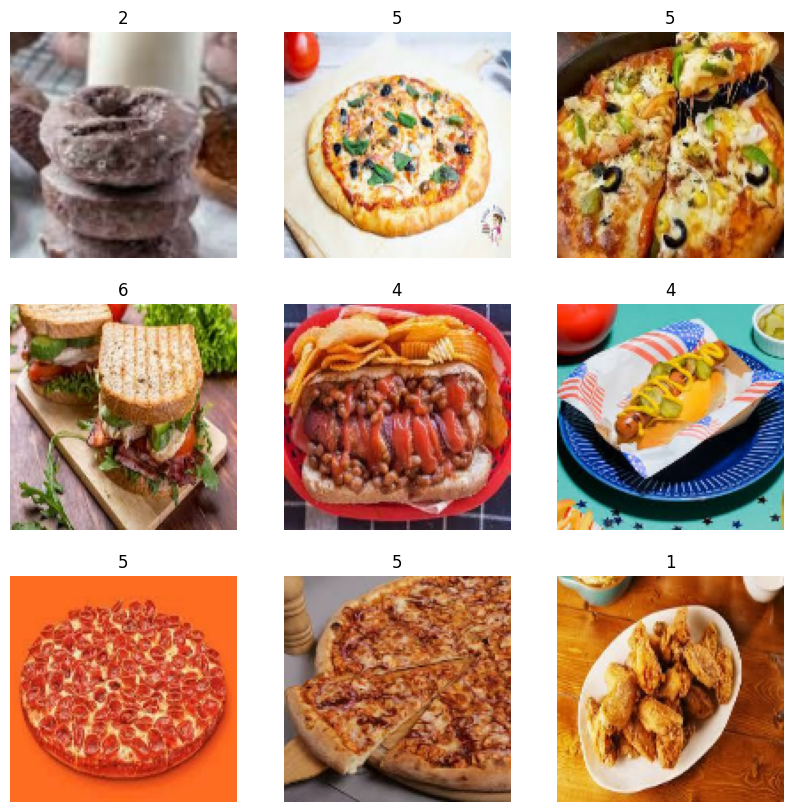

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Definimos las operaciones a realizar para el data augmentation

In [21]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Definimos el modelo de red neuronal a utilizar. Se utilizan cosas como el data augmentation de fifinido anteriormente o later.Dropout para evitar el overfitting.

In [34]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compilamos el modelo con la función de pérdida y el optimizador qe deseemos

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Entrenamos el modelo usando la gpu

In [42]:
epochs=10
history = None
with tf.device('/gpu:0'):
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Epoch 1/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0507 - accuracy: 0.9836 - val_loss: 3.3986 - val_accuracy: 0.5498
Epoch 2/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0380 - accuracy: 0.9878 - val_loss: 3.4263 - val_accuracy: 0.5512
Epoch 3/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0458 - accuracy: 0.9838 - val_loss: 3.6955 - val_accuracy: 0.5574
Epoch 4/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0521 - accuracy: 0.9855 - val_loss: 3.4090 - val_accuracy: 0.5427
Epoch 5/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0430 - accuracy: 0.9855 - val_loss: 3.8308 - val_accuracy: 0.5414
Epoch 6/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0432 - accuracy: 0.9876 - val_loss: 3.8124 - val_accuracy: 0.5302
Epoch 7/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0426 - accuracy: 0.9868 - val_loss: 3.4338 - val_accuracy: 0.5610
Epoch 

Mostramos un resumen del entrenamiento

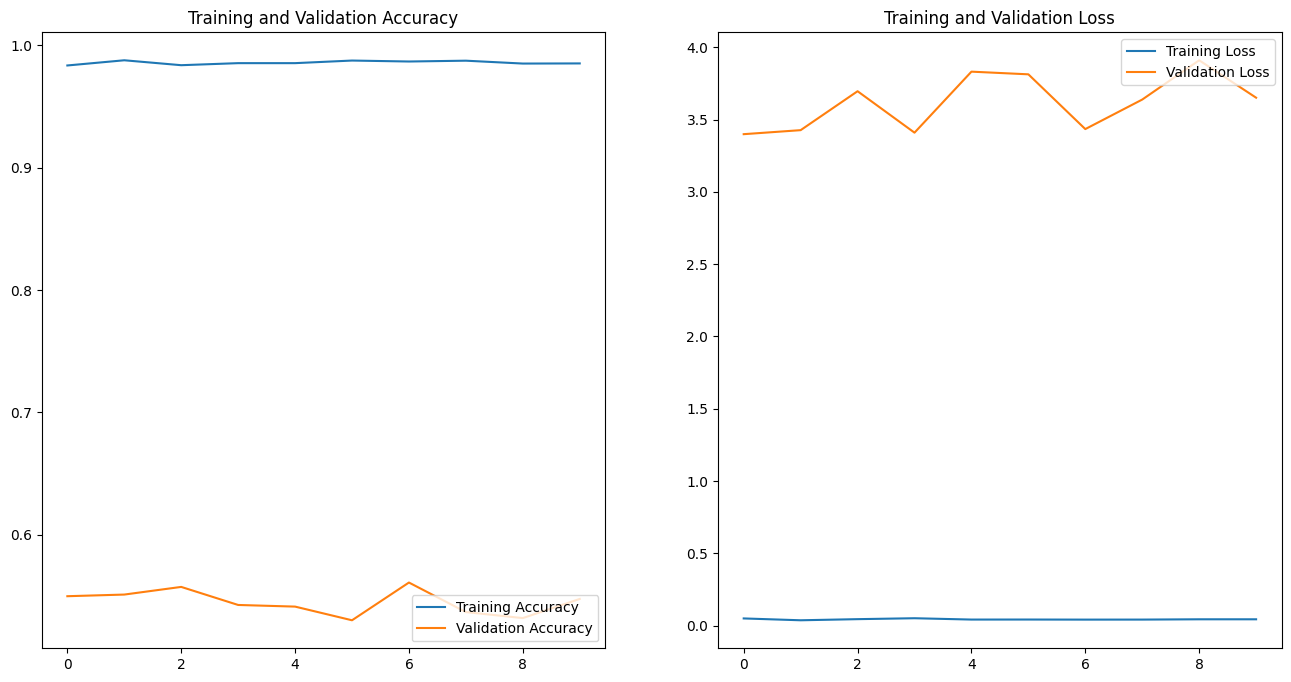

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predicciones

Vamos a proceder a realizar las predicciones para el conjunto de test y generar el archivo de submision

In [44]:
test_csv = pd.read_csv('test2.csv')
test_csv

,idx_test,path_img
0,0,data\test\ec4c75ba-e064-4ed0-a7b1-3ed899424110...
1,1,data\test\114fb94d-3223-4d95-b6d1-f6a6ac206ea2...
2,2,data\test\a80e7e27-a25a-40aa-a65c-a29bfa172b3d...
3,3,data\test\7848d24e-207a-4236-9cd7-df78122d8787...
4,4,data\test\57f726bc-d141-42fb-88fa-60d554499277...
...,...,...
4792,4792,data\test\5ad5bee4-c18b-48b7-921a-f10ee9a17ad1...
4793,4793,data\test\99ec9e46-6bff-463c-af86-6b38aecb9a39...
4794,4794,data\test\9ab954c9-8f13-4270-9b66-e669169b1f4f...
4795,4795,data\test\f41894e0-bed2-4b47-a8bc-2bab477d8ee7...


Cargamos las imagenes a predecir

In [45]:
imgs = []
for row in test_csv.iterrows():
  idx_test, path_img = row[1]
  img = tf.keras.utils.load_img(path_img, target_size=(img_height, img_width))
  img_arr = tf.keras.utils.img_to_array(img)
  imgs.append(img_arr)
imgs = np.array(imgs)

Realizamos las predicciones

In [46]:
predictions = model.predict(imgs)
labels = [int(class_names[np.argmax(tf.nn.softmax(pred))]) for pred in predictions]
test_csv.loc[:,'label'] = labels
test_csv

150/150 [==============================] - 1s 3ms/step


,idx_test,path_img,label
0,0,data\test\ec4c75ba-e064-4ed0-a7b1-3ed899424110...,5
1,1,data\test\114fb94d-3223-4d95-b6d1-f6a6ac206ea2...,2
2,2,data\test\a80e7e27-a25a-40aa-a65c-a29bfa172b3d...,6
3,3,data\test\7848d24e-207a-4236-9cd7-df78122d8787...,6
4,4,data\test\57f726bc-d141-42fb-88fa-60d554499277...,5
...,...,...,...
4792,4792,data\test\5ad5bee4-c18b-48b7-921a-f10ee9a17ad1...,1
4793,4793,data\test\99ec9e46-6bff-463c-af86-6b38aecb9a39...,2
4794,4794,data\test\9ab954c9-8f13-4270-9b66-e669169b1f4f...,1
4795,4795,data\test\f41894e0-bed2-4b47-a8bc-2bab477d8ee7...,7


Guardamos las predicciones en un archivo json

In [47]:
with open('submission.json', 'w') as f:
  f.write(json.dumps({ 'target': dict(zip(test_csv['idx_test'], test_csv['label'])) }, indent=2))